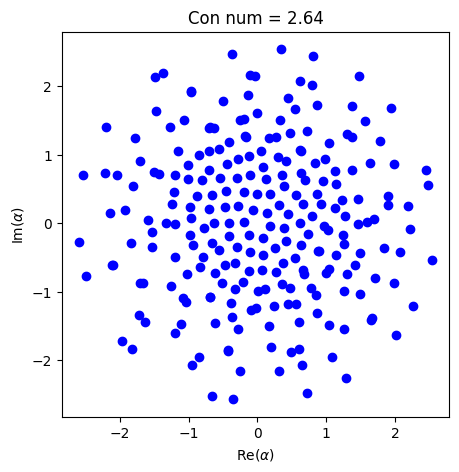


--- 3361.829327583313 seconds ---


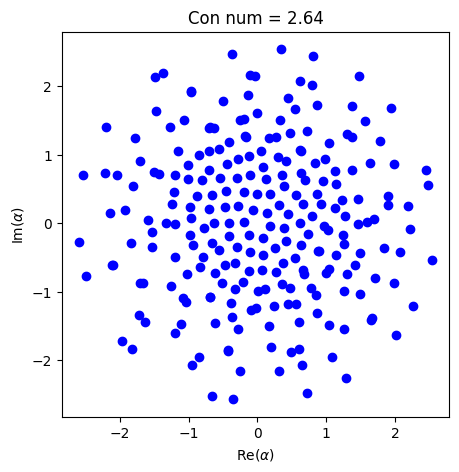

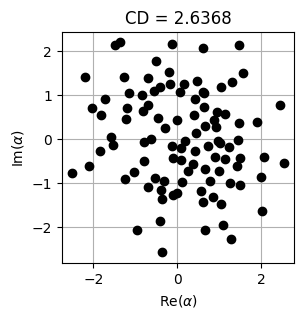

In [1]:
# %%
# matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
from scipy.linalg import expm
from scipy.optimize import minimize
from IPython.display import display, clear_output
from qutip import *
from QN_regression import QN_regression
import time

start_time = time.time()  # checking how long the code takes

FD = 10  # dimension to read
n_disps = 240  # total no of amplitudes
st = 2
cdim = 50  # cavity dimension
d = FD  # dimension to read
# qdim = 2
# ug = fock(qdim,0).full()
# q = tensor(destroy(qdim), qeye(cdim)).full() #annihilation for qubit
a = destroy(cdim).full()  # tensor(qeye(qdim),destroy(cdim)).full() #annihilation for cavity
# qdag = np.transpose(np.conj(q))
adag = np.transpose(np.conj(a))
P = expm(1j * np.pi * adag @ a)

NN = 1
dx = 0.001

# getting the K matrix, rho=K*Y+theta
n_para = FD ** 2 - 1
Ntr = FD ** 2
X_R = np.zeros([1 + n_para, Ntr], dtype=np.complex_)  # store readouts
X_R[0, :] = np.ones([1, Ntr])  # setting the ones
Y_R = np.zeros([FD ** 2, Ntr], dtype=np.complex_)  # store the targets
for j in np.arange(0, Ntr):
    # qudit mixed state embedded in the cavity mode
    rd1 = np.zeros([cdim, cdim], dtype=np.complex_)
    u_rand = rand_ket(FD)
    r_rand = (u_rand * u_rand.dag()).full()
    rd1[0:FD, 0:FD] = r_rand  # randRho(D)

    # assign X_r
    cw = 1
    # diagonal elements
    for j1 in np.arange(0, FD - 1):
        X_R[cw, j] = rd1[j1, j1].real
        cw += 1
    # off-diagonal elements
    for j1 in np.arange(0, FD - 1):
        for j2 in np.arange(j1 + 1, FD):
            X_R[cw, j] = rd1[j1, j2].real
            cw += 1
            X_R[cw, j] = rd1[j1, j2].imag
            cw += 1

    # assign Y_r
    Y_R[:, j] = np.transpose((np.transpose(r_rand)).reshape((FD ** 2, 1)))  # ideal rvec
Error, beta = QN_regression(X_R, Y_R, 0)
print(f'Error is {Error}')

K = beta[:, 1:n_para + 1]


# optimization from here
# H0 = 1*1j*np.pi*(adag@a@qdag@q)
# proj = np.kron(ug@np.transpose(np.conj(ug)),np.eye(cdim))

def wigner_mat(disps):
    ND = len(disps)  # no of exp points/displacements, equals n_disps
    # al1 = disps[:d**2]
    # al2 = disps[d**2:]
    M = np.zeros([ND, d ** 2], dtype=complex)  # the big map (truncated)
    for k in np.arange(0, ND):
        al = disps[k]
        # be = al2[k]*1
        U = expm(al * adag - np.conj(al) * a)

        MS = U @ P @ np.transpose(np.conj(U))
        # MS = proj@MS@proj
        # Ms = Qobj(MS, dims=[[qdim,cdim],[qdim,cdim]]).ptrace(1).full()
        # Ms = MS[0:cdim,0:cdim]

        Mst = MS[0:d, 0:d]  # truncation starts here
        M[k, :] = Mst.reshape((1, d ** 2))
    M_new = np.matmul(M, K)
    return M_new


def wigner_mat_and_grad(disps):
    ND = len(disps)  # no of exp points/displacements, equals n_disps
    wig_tens = np.zeros((ND, FD ** 2 - 1), dtype=complex)
    grad_mat_r_a = np.zeros((ND, FD ** 2 - 1), dtype=complex)
    grad_mat_i_a = np.zeros((ND, FD ** 2 - 1), dtype=complex)
    # grad_mat_r_q = np.zeros((ND, FD**2), dtype=complex)
    # grad_mat_i_q = np.zeros((ND, FD**2), dtype=complex)

    wig_tens = wigner_mat(disps)
    # now the change
    # dela = np.zeros(len(disps), dtype=np.complex_)
    # dela[:ND] = 1 
    # delq = np.zeros(len(disps), dtype=np.complex_)
    # delq[ND:] = 1
    # in displacements
    disps_dr_a = disps + dx  # *dela
    disps_di_a = disps + dx * 1j  # *dela
    # disps_dr_q = disps+dx*delq
    # disps_di_q = disps+dx*1j*delq
    # in matrices
    wig_tens_dr_a = wigner_mat(disps_dr_a)
    wig_tens_di_a = wigner_mat(disps_di_a)
    # wig_tens_dr_q = wigner_mat(disps_dr_q)
    # wig_tens_di_q = wigner_mat(disps_di_q)

    grad_mat_r_a = (wig_tens_dr_a - wig_tens) / dx
    grad_mat_i_a = (wig_tens_di_a - wig_tens) / dx
    # grad_mat_r_q = (wig_tens_dr_q-wig_tens)/dx
    # grad_mat_i_q = (wig_tens_di_q-wig_tens)/dx

    return (wig_tens, grad_mat_r_a, grad_mat_i_a)  # , grad_mat_r_q, grad_mat_i_q)


def cost_and_grad(r_disps):
    Nn = len(r_disps)
    c_disps = r_disps[:int(Nn / 2)] + 1j * r_disps[int(Nn / 2):]  # now complex displacements
    M, dM_rs_a, dM_is_a = wigner_mat_and_grad(c_disps)
    U, S, Vd = svd(M)
    NS = len(Vd)
    cn = S[0] / S[-1]
    dS_r_a = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_rs_a, Vd.conj().T).real
    dS_i_a = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_is_a, Vd.conj().T).real
    # dS_r_q = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_rs_q , Vd.conj().T).real
    # dS_i_q = np.einsum('ij,jk,ki->ij', U.conj().T[:NS], dM_is_q , Vd.conj().T).real
    grad_cn_r_a = (dS_r_a[0] * S[-1] - S[0] * dS_r_a[-1]) / (S[-1] ** 2)
    grad_cn_i_a = (dS_i_a[0] * S[-1] - S[0] * dS_i_a[-1]) / (S[-1] ** 2)
    # grad_cn_r_q = (dS_r_q[0]*S[-1] - S[0]*dS_r_q[-1])/(S[-1]**2)
    # grad_cn_i_q = (dS_i_q[0]*S[-1] - S[0]*dS_i_q[-1])/(S[-1]**2)
    return cn, np.concatenate((grad_cn_r_a, grad_cn_i_a))


best_cost = float('inf')
f, ax = plt.subplots(figsize=(5, 5))


def wrap_cost(disps):
    global best_cost
    cost, grad = cost_and_grad(disps)
    best_cost = min(cost, best_cost)
    ax.clear()
    ax.plot(disps[:n_disps], disps[n_disps:], 'ob')  # ok
    ax.set_title('Con num = %.2f' % (cost,))
    ax.set_xlabel('Re' + r'$(\alpha)$')
    ax.set_ylabel('Im' + r'$(\alpha)$')
    clear_output(wait=True)
    display(f)
    # print(cost)
    # print 'nr%s (%s)' % (cost , best cost),
    # print(grad)
    return cost, grad


CD = np.zeros(NN)
DIS = np.zeros([NN, n_disps], dtype=np.complex_)
for vv in np.arange(0, NN):
    init_disps = np.random.normal(0, 0.5 * st, 2 * n_disps)  # random numbers
    # init_disps = np.array([ 1.47550433, -1.07029609, -0.10366203, -0.56023532, -0.26149839,-1.01849083,  0.95176108,  1.63069871])
    # for k in np.arange(len(new_disps)):
    #     init_disps[k] = new_disps[k].real
    #     init_disps[k+n_disps] = new_disps[k].imag

    init_disps[0] = init_disps[n_disps] = 0  # putting zeros, corresponding to 0,0j
    ret = minimize(wrap_cost, init_disps, method='L-BFGS-B', jac=True, options=dict(ftol=1e-6))
    # print(ret.message)

    new_disps = ret.x[:n_disps] + 1j * ret.x[n_disps:]

    CD[vv] = ret.fun
    DIS[vv, :] = new_disps
# print(min(CD))

sorted_index = np.argsort(CD)
final_disps = DIS[sorted_index[0], :]
al1 = final_disps
final_al1 = final_disps[:d ** 2 - 1]
# final_al2 = final_disps[d**2:]
final_CD = CD[sorted_index[0]]
# plotting the optimum displacements
fig = plt.figure(figsize=(3, 3))
for k in np.arange(0, len(final_al1)):
    plt.plot(final_al1[k].real, final_al1[k].imag, 'ok')
# for k in np.arange(0,len(final_al2)):
#     plt.plot(final_al2[k].real,final_al2[k].imag,'or')
plt.xlabel('Re' + r'$(\alpha)$')
plt.ylabel('Im' + r'$(\alpha)$')
plt.title('CD = %.4f' % (final_CD))
plt.grid()
np.save("disps2", final_disps)
print("")
print("--- %s seconds ---" % (time.time() - start_time))
# %%

In [ ]:
3.24